In [47]:
using Images
using PyPlot
using Clustering


include("Common.jl")

#---------------------------------------------------------
# Type aliases for arrays of images/features
#---------------------------------------------------------
typealias ImageList Array{Array{Float64,2},1}
typealias FeatureList Array{Array{Float64,2},1}


#---------------------------------------------------------
# Structure for storing datasets
#
# Fields:
#   images      images associated with this dataset
#   labels      corresponding labels
#   n           number of examples
#---------------------------------------------------------
type Dataset
  images::Array{Array{Float64,2},1}
  labels::Array{Float64,1}
  n::Int
end

#---------------------------------------------------------
# Provides Dataset.length() method.
#---------------------------------------------------------
import Base.length
function length(x::Dataset)
  @assert length(x.images) == length(x.labels) == x.n "The length of the dataset is inconsistent."
  return x.n
end


#---------------------------------------------------------
# Structure for storing SIFT parameters.
#
# Fields:
#   fsize         filter size
#   sigma         standard deviation for filtering
#   threshold     SIFT threshold
#   boundary      number of boundary pixels to ignore
#---------------------------------------------------------
type Parameters
  fsize::Int
  sigma::Float64
  threshold::Float64
  boundary::Int
end



#---------------------------------------------------------
# Create input data by separating planes and bikes randomly
# into two equally sized sets.
#
# Note: Use the Dataset type from above.
#
# OUTPUTS:
#   trainingset      Dataset of length 120, contraining bike and plane images
#   testingset       Dataset of length 120, contraining bike and plane images
#
#---------------------------------------------------------
function loadimages()
    
## first generate the random number of training bike images we  want , say n  from 106 bikes
## then find n random indices of images from bike set
## find 120-n random indices of images from airplane set
## training set done
##3 we will have now 106-n images for bike set for testing and 134-120+n images from plane set for testing
##***********************Random Image Number Generation *************************#
    
    no_bike_train = rand(1:1:106)   ## we get the random value of bikes we want to training
    bike_training = randperm(106)[1:no_bike_train]    ## generate unique random indexes between 1:106
    no_bike_test = 106-no_bike_train
    bike_testing = zeros(Int64,(no_bike_test,1))
##  find bike sets for testing
    
    k = 1
    for i = 1:106
     if sum(find(bike_training.== i))==0   ##find index i in the bike_training set, if not found it goes for testing
       bike_testing[k] = i
        k = k+1
      end
    end

    no_plane_train= 120- no_bike_train   ## no of planes for testing
    plane_training = randperm(134)[1:no_plane_train]    ## these are the random indexes for plane training

    no_plane_test = 134-no_plane_train   ## no of testing planes sets
    plane_testing = zeros(Int64,(no_plane_test,1))
## going to find bike sets for testing
   k = 1
    for i=1:134
     if sum(find(plane_training.== i))==0   ##find index i in the plane_training set, if not found it goes for testing
        plane_testing[k]=i
        k=k+1   
     end
    end
    
 #*************************Random Image Number Generation DONE********************************#
    
    training = Array{Array{Float64,2}}(120)
    testing = Array{Array{Float64,2}}(120)
    training_Labels = Array{Float64,1}(120)
    testing_Labels = Array{Float64,1}(120)


#loads all training images
    for i=1:no_bike_train
         training[i] = PyPlot.imread(@sprintf("bikes/%03i.png",bike_training[i]))    
         training_Labels[i] = 1
    end
    
## reading upto 3 digit precision
    for i=1:size(plane_training,1)
#starting from index offset no_bike_train
        training[no_bike_train+ i] = PyPlot.imread(@sprintf("planes/%03i.png",plane_training[i]))
        training_Labels[no_bike_train+i] = 0
    end


#loads all training images
    for i=1:no_bike_test
        testing[i] = PyPlot.imread(@sprintf("bikes/%03i.png",bike_testing[i]))
        testing_Labels[i] = 1
    end
## reading upto 3 digit precision
    for i=1:size(plane_testing,1)
#starting from index offset no_bike_test
        testing[no_bike_test+ i] = PyPlot.imread(@sprintf("planes/%03i.png",plane_testing[i]))
        testing_Labels[no_bike_test+i] = 0
    end  
   
#display(training)
#display(testing)
    trainingset = Dataset(training, training_Labels, 120)
    testingset = Dataset(testing, testing_Labels, 120)
  @assert length(trainingset) == 120
  @assert length(testingset) == 120
  return trainingset::Dataset, testingset::Dataset
end


#---------------------------------------------------------
# Extract features for all images using im2feat for each
#---------------------------------------------------------
function extractfeatures(images::ImageList,params::Parameters)
    features = Array{Array{Float64,2}}(120)
    for i=1:120   
         features[i]= im2feat(images[i],params.fsize,params.sigma,params.threshold,params.boundary)
    end  
  @assert length(features) == length(images)
  return features::FeatureList
end


#---------------------------------------------------------
# Extract features for a single image by applying Harris detection
# to find interest points and SIFT to compute the features at these points.
#---------------------------------------------------------
function im2feat(im::Array{Float64,2},fsize::Int,sigma::Float64,threshold::Float64,boundary::Int)
    
    px1,py1 = Common.detect_interestpoints(im, sigma, fsize, threshold,boundary)
    keypoints1 = [px1 py1]
    F = Common.sift(keypoints1,im,sigma)
  @assert size(F,1) == 128
  return F::Array{Float64,2}
end


#---------------------------------------------------------
# Build a concatenated feature matrix from all given features
#---------------------------------------------------------
function concatenatefeatures(features::FeatureList)

  X = features[1]   ## initiliase it with first image features
  for i=2:120
    X = [X features[i]]
  end  
  @assert size(X,1) == 128
  return X::Array{Float64,2}
end

#---------------------------------------------------------
# Build a codebook for a given feature matrix by k-means clustering with K clusters
#---------------------------------------------------------
function computecodebook(X::Array{Float64,2},K::Int)

   R = kmeans(X, K)
   codebook = R.centers
  @assert size(codebook) == (size(X,1),K)
  return codebook::Array{Float64,2}
end


#---------------------------------------------------------
# Compute a histogram over the codebook for all given features
#---------------------------------------------------------
function computehistogram(features::FeatureList,codebook::Array{Float64,2},K::Int)
    #traininghistogram = computehistogram(trainingfeatures,codebook,K)
    #=we have training_features which contains the features of all the feature points from all the training images and we have 	codebook  which has grouped these fures into  50 groups =#
    ## we have to compute histogram for each image 

    #lets take training_features[1] as input as this is the first training image
    #histogram_features_TR = Array{Array{Float64,2}}(120)  ## 120 rows of 
    #histogram_features_TE = Array{Array{Float64,2}}(120)  ## 120 rows of 
    
    img_Count = size(features,1)
    H = zeros(Float64,K,img_Count)  ## 120 rows of 

    for loop = 1:img_Count  ## loops for all image
        s = features[loop]  ## get hold of all the features of this image
        smallest_index = zeros(Int64,1,size(s,2))   ## stores the codeword index corresponding to each feature
        count_index = zeros(Int64,1,K)   ## stores the number of occurance of code word in each image

        for i=1:size(s,2)    ##  features of an image[loop]
            ssd_min = sum(abs2.(s[:,i]-codebook[:,1]))  # initialize with first entry
            smallest_index[i] = 1
            for j=1:K   ## these are the codewords
                ssd_calc = sum(abs2.(s[:,i]-codebook[:,j]))
                if ssd_calc<ssd_min
                smallest_index[i] = j  ## each feature of each image corresponds to which codeword index
                ssd_min = ssd_calc
            end
        end
end
 
    for counter=1:K       
        count_index[counter] = count(v->v==counter,smallest_index)   #count occurence of each codeword for the image
    end
        
    count_index = count_index./sum(count_index)  # normalise the histogram
#display(count_index)

    H[:,loop] = count_index'    ##  contains normalised histogram of all features of image[loop]       
end
   

## training histogram feature tells the number of occurences of features as per codeword in each training image

  @assert size(H) == (K,length(features))
  return H::Array{Float64,2}
end


#---------------------------------------------------------
# Visualize a feature matrix by projection to the first
# two principal components. Points get colored according to class labels y.
#---------------------------------------------------------
function visualizefeatures(X::Array{Float64,2}, y)
    img_count = size(y,1)
    g=count(w -> w == 1,y)  ## gets count of number of bikes
    
    data = X'
    mu=zeros(size(data,1))
    mu=(mean(data,2))
    detrended_X = data.-mu 

    _,S,V = svd(detrended_X,thin=false)
    X1 = detrended_X*V[:,1]
    Y1 = detrended_X*V[:,2]
    figure()
    scatter(X1[1:g],Y1[1:g],color="red") ##bikes
    scatter(X1[g+1:img_count],Y1[g+1:img_count],color="blue")  ##planes
    PyPlot.title("PCA Projection of bike images(red) and airplane images(blue)")
   
  
 return nothing
end


# Problem 2: Bag of Words Model: Codebook

function problem2()
  # parameters
  params = Parameters(15,1.4,1e-7,10)
  K = 50

  # load trainging and testing data
  traininginputs,testinginputs = loadimages()

  # extract features from images
  trainingfeatures = extractfeatures(traininginputs.images,params)
  testingfeatures = extractfeatures(testinginputs.images,params)

  # construct feature matrix from the training features
  X = concatenatefeatures(trainingfeatures)

  # write codebook
  codebook = computecodebook(X,K)

  # compute histogram
  traininghistogram = computehistogram(trainingfeatures,codebook,K)
  testinghistogram = computehistogram(testingfeatures,codebook,K)

  # visualize training features
  visualizefeatures(traininghistogram, traininginputs.labels)
 

  return nothing
end



Use "const ImageList = Array{Array{Float64,2},1}" instead.

Use "const FeatureList = Array{Array{Float64,2},1}" instead.


problem2 (generic function with 1 method)

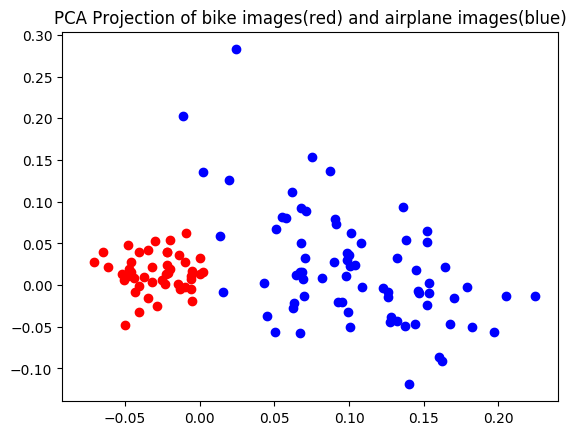

In [48]:
problem2()